Quickstart
=================
*01/2021: updated to pyGDM v1.1+*

This is a minimal example to demonstrate how to setup an run a simulation in pyGDM. For more examples, please have a look at the **tutorials** and **examples** sections.

We start by loading the pyGDM modules that we are going to use:

Load the modules
-------------------

In [1]:
## --- Load the pyGDM modules 
from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields
from pyGDM2 import propagators
from pyGDM2 import core
from pyGDM2 import visu
from pyGDM2 import tools

Now we have to setup the actual simulation. This contains (1) the nano-particle geometry and its environment and (2) the incident electro-magnetic field.
Finally we need to create an instance of a *simulation* object which contains the above mentioned information.

Setup (1): Particle geometry and environment
--------------------------------------

In [2]:
## --- stepsize on the discretization grid
step = 20

## --- structure: sphere of 120nm radius discretized on a cubic lattice
geometry = structures.sphere(step, R=6, mesh='cube')

## --- constant dielectric function,
material = materials.dummy(2.0)

## --- finally: wrap it all up in the "structure" object. 
## note: since pyGDM v1.1, the mesh-dependent normalization is automatically determined internally
##       furthermore, while the old convention still works, the environment should now be defined 
##       together with a "Dyads" class.
struct = structures.struct(step, geometry, material)

structure initialization - automatic mesh detection: cube
structure initialization - consistency check: 1021/1021 dipoles valid


Setup (2): Fundamental (incident) field
---------------------------------------------

In [3]:
## --- for now, we want a simple plane wave
## note: this is a new function (the old one is still available with the same name `planewave`)
##       The new plane wave supports arbitrary incident angles and polarizations.
##       It also correctly takes into account a possible substrate and/or cladding layer
field_generator = fields.plane_wave

## --- the configuration is passed via a list "wavelengths", 
## --- containing the wavelengths (in nm): 
wavelengths = [400]

## --- ... and a dictionary with all other kwargs that are
## --- available for the selected field-generator. The wavelength is
## --- treated seperately because pyGDM is a frequency-domain 
## --- solver. The main inversion problem will be solved once for
## --- each wavelength and then evaluated for every field 
## --- configuration.
## --- For now, we want to simulate simply a single incident field.
## --- We use a polarization along X (--> p-polarization in xz scattering plane)
## --- Incidence is along -z (from top), described by an angle of 180 degrees
kwargs = dict(E_p=1, E_s=0, inc_angle=[180])

## --- finally: wrap it up in the "efield" object
efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs)

Setup (3): Environment / sim. type
---------------------------------------------

In [4]:
## now we setup the class of Greens tensors (Dyads) defining the environment
## n1: substrate refractive index
## n2: top environment index
n1, n2 = 1, 1
dyads = propagators.DyadsQuasistatic123(n1=n1, n2=n2)

Setup (4): Wrap all up in the *simulation* object
--------------------------------------------

In [5]:
## --- the "simulation"-object contains all above information
## --- defining the numerical experiment
sim = core.simulation(struct, efield, dyads)

Print information about the simulation
---------------------------------------

In [6]:
## --- let's get a summary of the simulation config.
print(sim)


 =============== GDM Simulation Information ===============
precision: <class 'numpy.float32'> / <class 'numpy.complex64'>


 ------ nano-object -------
   Homogeneous object. 
   material:             "constant index material, n=(2+0j)"
   mesh type:            cubic
   nominal stepsize:     20nm
   nr. of meshpoints:    1021

 ----- incident field -----
   field generator: "plane_wave"
   1 wavelengths between 400 and 400nm
   1 incident field configurations per wavelength

 ------ environment -------
   n3 = constant index material, n=(1+0j)  <-- top
   n2 = constant index material, n=(1+0j)  <-- center layer (height "spacing" = 5000nm)
   n1 = constant index material, n=(1+0j)  <-- substrate

 ===== *core.scatter* ======
   NO self-consistent E-fields
   NO self-consistent H-fields


Plot structure geometry
--------------------------------------------

Let's see what the structure looks like

/home/hans/.local/lib/python3.8/site-packages/pyGDM2/visu.py:48: UserWarning: 3D data. Falling back to XY projection...
  warnings.warn("3D data. Falling back to XY projection...")


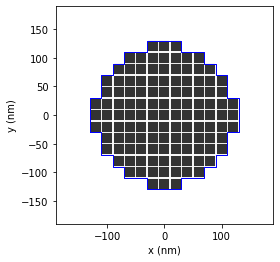

In [7]:
im = visu.structure(sim, show=False)
ct = visu.structure_contour(sim, show=True)

Run the simulation
--------------------

In [8]:
## Note that in pyGDM v1.1+ the whole calculation is written in numba-accelerated pure python
## numba performs a internal compilation upon the first call of a function, therefore the first 
## simulation step is usually significantly slower than subsequent simulation steps in the same run
sim.scatter()

/home/hans/.local/lib/python3.8/site-packages/numba/core/dispatcher.py:238: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  entrypoints.init_all()


timing for wl=400.00nm - setup: EE 10598.9ms, inv.: 1119.7ms, repropa.: 7837.3ms (1 field configs), tot: 19556.2ms


1

Visualize the result
-------------------------

Let's see what we got. We want to plot the real part of the electric field inside the nanoparticle. We will also add a plot of the structure's contour and do this for projections on all three planes of the carthesian coordinate system:

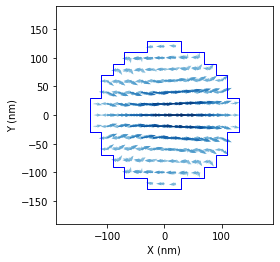

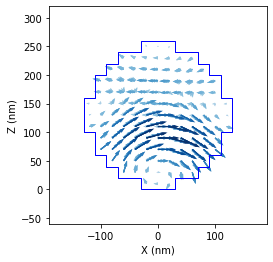

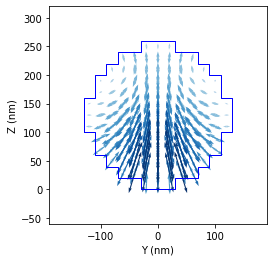

In [9]:
## --- plot the near-field inside the sphere
## using first (of one) field-config (=index 0)
qv = visu.vectorfield_by_fieldindex(sim, 0, projection='XY', show=False)
ct = visu.structure_contour(sim, projection='XY', show=True)

qv = visu.vectorfield_by_fieldindex(sim, 0, projection='XZ', show=False)
ct = visu.structure_contour(sim, projection='XZ', show=True)

qv = visu.vectorfield_by_fieldindex(sim, 0, projection='YZ', show=False)
ct = visu.structure_contour(sim, projection='YZ', show=True)

**Note:** Here we implicitly introduced the *fieldindex*, used throughout pyGDM. We plotted the field with fild_index "0": 

    visu.vectorfield_by_fieldindex(sim, 0, ...)
  
pyGDM will automatically generate all possible permutations of field-configurations described in the *efield* object.
The *fieldindex* is used to unambiguoulsy identify the field-configurations (such as different wavelengths or incident polarizations). In the case of this simple example, we only have one single configuration: 400nm wavelength, X-polarization, incidence along -z.

For more info on the field-index convention in pyGDM, see the tutorial on calculating spectra.